In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

# 1. Imports & global settings

In [22]:
# =========================
# Imports & global settings (GPU + legacy-safe plotting)
# =========================
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---- Plot style (try modern seaborn first, then fall back) ----
try:
    plt.style.use("seaborn-v0_8")
except Exception:
    try:
        plt.style.use("seaborn")
    except Exception:
        # Keep Matplotlib default if neither style is available
        pass

plt.rcParams["font.family"] = "serif"

# ---- Inline plotting in notebooks (safe if not in IPython) ----
try:
    from IPython import get_ipython
    ipy = get_ipython()
    if ipy is not None:
        ipy.run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ---- Reproducibility ----
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# For deterministic behavior (slightly slower). Comment out if you prefer speed.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # set True for speed if you don't need exact determinism

# ---- Device selection & report ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("PyTorch:", torch.__version__, "| Matplotlib:", matplotlib.__version__)
else:
    print("PyTorch:", torch.__version__, "| Matplotlib:", matplotlib.__version__)


Using device: cpu
PyTorch: 1.1.0 | Matplotlib: 3.0.3


# 2. Locate kaggle dataset

In [37]:
# =========================
# Locate kaggle dataset
# =========================
# This is only to help you see what datasets are mounted under /kaggle/input
import os, itertools

print("Subdirectories under /kaggle/input:")
subdirs = sorted(next(os.walk("/kaggle/input"))[1])
for d in subdirs:
    print("  -", d)

print("\nSample files (up to 5 per subdir):")
for d in subdirs:
    root = os.path.join("/kaggle/input", d)
    files = []
    # walk only this subdir (no break here)
    for _, _, fns in os.walk(root):
        files.extend(fns)
        if len(files) >= 5:
            break
    print(f"DIR: {root}")
    if files:
        for fn in sorted(files)[:5]:
            print("   ", fn)
    else:
        print("    (no files)")


Subdirectories under /kaggle/input:
  - Data
  - ETFs
  - Stocks

Sample files (up to 5 per subdir):
DIR: /kaggle/input/Data
    a.us.txt
    aa.us.txt
    aaap.us.txt
    aaba.us.txt
    aac.us.txt
DIR: /kaggle/input/ETFs
    aadr.us.txt
    aaxj.us.txt
    acim.us.txt
    actx.us.txt
    acwf.us.txt
DIR: /kaggle/input/Stocks
    a.us.txt
    aa.us.txt
    aaap.us.txt
    aaba.us.txt
    aac.us.txt


# 3. Utilities to find and load a stock

In [53]:
# ==================================
# Utilities to find and load a stock
# ==================================
import os
import pandas as pd
import numpy as np

# Prefer these roots; they exist in your environment
ROOTS = ["/kaggle/input/Stocks", "/kaggle/input/Data/Stocks"]

def find_stock_file(symbol_candidates):
    """
    Try to resolve '<symbol>.us.txt' under known roots, then fall back to a recursive search.
    symbol_candidates: e.g. ['googl', 'goog'] for GOOGL.
    Returns a full path if found, else raises FileNotFoundError.
    """
    # 1) Direct check in preferred roots (fast)
    for base in [s.lower() for s in symbol_candidates]:
        filename = f"{base}.us.txt"
        for root in ROOTS:
            path = os.path.join(root, filename)
            if os.path.exists(path):
                return path

    # 2) Fallback: recursive search (slow but robust)
    for root, _, files in os.walk("/kaggle/input"):
        lower_map = {f.lower(): f for f in files}
        for base in [s.lower() for s in symbol_candidates]:
            target = f"{base}.us.txt"
            if target in lower_map:
                return os.path.join(root, lower_map[target])

    raise FileNotFoundError(f"Could not find {symbol_candidates} with '*.us.txt' under /kaggle/input")


def load_single_symbol(symbol, start='2010-01-01', end='2019-12-31'):
    df = pd.read_csv(
        path, usecols=["Date","Close"], parse_dates=["Date"], index_col="Date"
    ).sort_index()

    # Clip the requested window to the actual data window
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)
    data_start = df.index.min()
    data_end   = df.index.max()
    start_clipped = max(start, data_start)
    end_clipped   = min(end, data_end)

    # Reindex only within [start_clipped, end_clipped]
    bdays = pd.date_range(start=start_clipped, end=end_clipped, freq="B")
    df = df.reindex(bdays)
    df.columns = [symbol]

    # Fill gaps inside the clipped window; no tail “smearing” beyond last real date
    df = df.ffill().bfill()
    df = df.dropna()

    return df




In [54]:
# --- Quick sanity checks: do we see the roots and can we load each ticker? ---
print("Roots exist:", {r: os.path.exists(r) for r in ["/kaggle/input/Stocks", "/kaggle/input/Data/Stocks"]})

# Important: correct spelling is AAPL (not APPL)
TICKERS = ["AAPL", "AMZN", "GOOGL", "MSFT", "TSLA"]

for t in TICKERS:
    try:
        # Show the resolved path first
        if t == "GOOGL":
            # try both names; your loader already does this internally
            from pprint import pprint
        path = find_stock_file({"AAPL":["aapl"],"AMZN":["amzn"],"GOOGL":["googl","goog"],
                                "MSFT":["msft"],"TSLA":["tsla"]}[t])
        print(f"[{t}] file:", path)

        # Try loading a small slice to verify parsing
        df_sample = load_single_symbol(t, start="2015-01-01", end="2015-03-31")
        print(f"[{t}] shape:", df_sample.shape)
        print(df_sample.head(3))
    except Exception as e:
        print(f"[{t}] FAILED -> {e}")


Roots exist: {'/kaggle/input/Stocks': True, '/kaggle/input/Data/Stocks': True}
[AAPL] file: /kaggle/input/Stocks/aapl.us.txt
[AAPL] shape: (64, 1)
              AAPL
2015-01-01  103.50
2015-01-02  103.50
2015-01-05  100.58
[AMZN] file: /kaggle/input/Stocks/amzn.us.txt
[AMZN] shape: (64, 1)
              AMZN
2015-01-01  308.52
2015-01-02  308.52
2015-01-05  302.19
[GOOGL] file: /kaggle/input/Stocks/googl.us.txt
[GOOGL] shape: (64, 1)
             GOOGL
2015-01-01  529.55
2015-01-02  529.55
2015-01-05  519.46
[MSFT] file: /kaggle/input/Stocks/msft.us.txt
[MSFT] shape: (64, 1)
              MSFT
2015-01-01  43.555
2015-01-02  43.555
2015-01-05  43.154
[TSLA] file: /kaggle/input/Stocks/tsla.us.txt
[TSLA] shape: (64, 1)
              TSLA
2015-01-01  219.31
2015-01-02  219.31
2015-01-05  210.09


# 4. Convert a univariate series to supervised sequences

In [55]:
# =====================================================
# Convert a univariate series to supervised sequences
# =====================================================
def create_sequences(values: np.ndarray, look_back: int):
    """
    values: shape (N, 1) scaled prices
    look_back: sequence length used to predict the next value
    Return:
        X: (num_samples, look_back-1, 1)
        y: (num_samples, 1)
    """
    data = []
    for i in range(len(values) - look_back):
        data.append(values[i : i + look_back])
    data = np.array(data)
    X = data[:, :-1, :]
    y = data[:, -1, :]
    return X, y


# 5. PyTorch LSTM model

In [56]:
# =====================
# PyTorch LSTM model
# =====================
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq, feat)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]           # last time step
        out = self.fc(out)            # (batch, 1)
        return out


# 6. Metrics (beyond MSE)

In [57]:
# =====================
# Metrics (beyond MSE)
# =====================
def evaluate_predictions(y_true, y_pred, prev_prices=None):
    """
    Compute multiple metrics given true and predicted prices (both 1D arrays).
    prev_prices: previous day's actual price aligned with y_true (for directional accuracy).
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0)
    r2 = r2_score(y_true, y_pred)

    # Directional accuracy (optional if prev_prices is provided)
    if prev_prices is not None and len(prev_prices) == len(y_true):
        actual_change = y_true - prev_prices
        pred_change = y_pred - prev_prices
        directional = float(np.mean(np.sign(actual_change) == np.sign(pred_change)) * 100.0)
    else:
        directional = np.nan

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape,
        "R2": r2,
        "Directional_Accuracy(%)": directional
    }


# 7. Train & evaluate one ticker

In [58]:
# ============================
# Train & evaluate one ticker (fit scaler on TRAIN ONLY to avoid leakage)
# ============================
def train_and_evaluate_symbol(
    symbol,
    look_back=60,
    train_ratio=0.8,
    hidden_dim=32,
    num_layers=2,
    lr=1e-3,                 # slightly lower LR is stabler
    batch_size=64,
    epochs=100,
    start='2010-01-01',
    end='2019-12-31',
    plot=True
):
    """
    Train an LSTM on a single ticker and return evaluation metrics.
    This version avoids data leakage by fitting the scaler ONLY on the training segment.
    """
    # 1) Load raw series (no scaling here)
    df = load_single_symbol(symbol, start=start, end=end)  # single column named as symbol
    values = df.values.astype(np.float32)                  # shape (N, 1)
    if not np.isfinite(values).all():
        raise ValueError(f"{symbol}: non-finite values in raw series.")

    # 2) Create sequences from RAW values (unscaled)
    #    X_all_raw: (num_samples, look_back-1, 1), y_all_raw: (num_samples, 1)
    X_all_raw, y_all_raw = create_sequences(values, look_back=look_back)
    n = len(X_all_raw)
    n_train = int(n * train_ratio)

    X_train_raw, y_train_raw = X_all_raw[:n_train], y_all_raw[:n_train]
    X_test_raw,  y_test_raw  = X_all_raw[n_train:], y_all_raw[n_train:]

    # 3) Fit scaler ONLY on training data
    #    Combine training inputs and targets so the scaler sees the full training value range.
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_flat = np.concatenate(
        [X_train_raw.reshape(-1, 1), y_train_raw.reshape(-1, 1)],
        axis=0
    )
    scaler.fit(train_flat)

    # 4) Transform both train/test using the TRAIN-fitted scaler
    X_train = scaler.transform(X_train_raw.reshape(-1, 1)).reshape(X_train_raw.shape)
    y_train = scaler.transform(y_train_raw)
    X_test  = scaler.transform(X_test_raw.reshape(-1, 1)).reshape(X_test_raw.shape)
    y_test  = scaler.transform(y_test_raw)

    if (not np.isfinite(X_train).all()) or (not np.isfinite(y_train).all()):
        raise ValueError(f"{symbol}: NaN/Inf after scaling (train).")
    if (not np.isfinite(X_test).all()) or (not np.isfinite(y_test).all()):
        raise ValueError(f"{symbol}: NaN/Inf after scaling (test).")

    # 5) To torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32, device=device)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    # 6) Model / loss / optimizer
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 7) Train
    hist = []
    model.train()
    for ep in range(epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        hist.append(epoch_loss)
        if (ep + 1) % 10 == 0 or ep == 0:
            print(f"[{symbol}] Epoch {ep+1}/{epochs} - Train MSE: {epoch_loss:.6f}")

    # 8) Predict on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).cpu().numpy()

    # 9) Inverse scaling back to price space
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

    # Directional accuracy needs the previous actual price aligned with test targets
    start_idx_in_original = n_train + (look_back - 1)
    full_prices = values.flatten()
    prev_for_test = full_prices[start_idx_in_original - 1 : start_idx_in_original - 1 + len(y_test_inv)]

    metrics = evaluate_predictions(y_test_inv, y_pred_inv, prev_prices=prev_for_test)

    # 10) Plots
    if plot:
        plt.figure(figsize=(8, 3))
        plt.plot(hist, label="Training MSE")
        plt.title(f"{symbol} - Training Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(12, 4))
        idx = df.index[-len(y_test_inv):]
        plt.plot(idx, y_test_inv, label="Actual", color="red")
        plt.plot(idx, y_pred_inv, label="Predicted", color="blue")
        plt.title(f"{symbol} Stock Price Prediction (Test)")
        plt.xlabel("Time"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

    return metrics


# 8. Run for 5 tickers and report


Training & evaluating AAPL
[AAPL] Epoch 1/100 - Train MSE: 0.107153
[AAPL] Epoch 10/100 - Train MSE: 0.001952
[AAPL] Epoch 20/100 - Train MSE: 0.001510
[AAPL] Epoch 30/100 - Train MSE: 0.001141
[AAPL] Epoch 40/100 - Train MSE: 0.001152
[AAPL] Epoch 50/100 - Train MSE: 0.001286
[AAPL] Epoch 60/100 - Train MSE: 0.001150
[AAPL] Epoch 70/100 - Train MSE: 0.001229
[AAPL] Epoch 80/100 - Train MSE: 0.001194
[AAPL] Epoch 90/100 - Train MSE: 0.001276
[AAPL] Epoch 100/100 - Train MSE: 0.001371


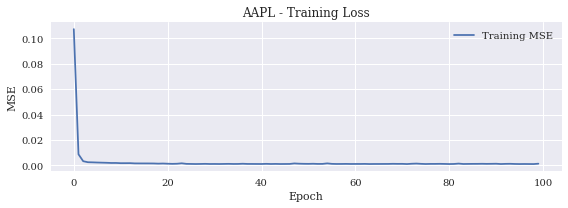

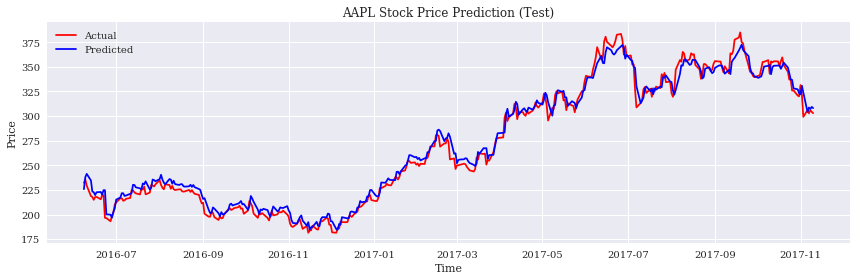


Training & evaluating AMZN
[AMZN] Epoch 1/100 - Train MSE: 0.104467
[AMZN] Epoch 10/100 - Train MSE: 0.001862
[AMZN] Epoch 20/100 - Train MSE: 0.001291
[AMZN] Epoch 30/100 - Train MSE: 0.001135
[AMZN] Epoch 40/100 - Train MSE: 0.001126
[AMZN] Epoch 50/100 - Train MSE: 0.001194
[AMZN] Epoch 60/100 - Train MSE: 0.001198
[AMZN] Epoch 70/100 - Train MSE: 0.001167
[AMZN] Epoch 80/100 - Train MSE: 0.001195
[AMZN] Epoch 90/100 - Train MSE: 0.001118
[AMZN] Epoch 100/100 - Train MSE: 0.001261


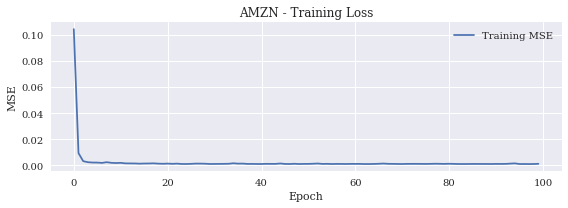

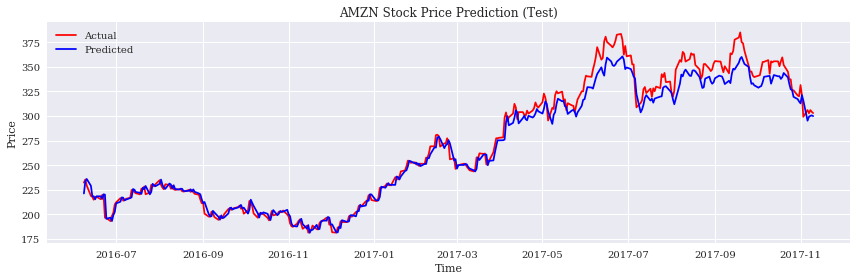


Training & evaluating GOOGL
[GOOGL] Epoch 1/100 - Train MSE: 0.136334
[GOOGL] Epoch 10/100 - Train MSE: 0.002199
[GOOGL] Epoch 20/100 - Train MSE: 0.001458
[GOOGL] Epoch 30/100 - Train MSE: 0.001406
[GOOGL] Epoch 40/100 - Train MSE: 0.001279
[GOOGL] Epoch 50/100 - Train MSE: 0.001242
[GOOGL] Epoch 60/100 - Train MSE: 0.001350
[GOOGL] Epoch 70/100 - Train MSE: 0.001463
[GOOGL] Epoch 80/100 - Train MSE: 0.001072
[GOOGL] Epoch 90/100 - Train MSE: 0.001082
[GOOGL] Epoch 100/100 - Train MSE: 0.001293


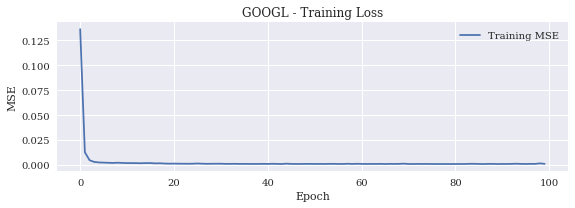

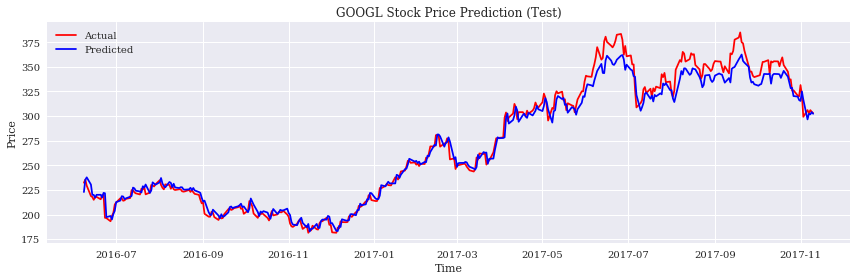


Training & evaluating MSFT
[MSFT] Epoch 1/100 - Train MSE: 0.130206
[MSFT] Epoch 10/100 - Train MSE: 0.002053
[MSFT] Epoch 20/100 - Train MSE: 0.001405
[MSFT] Epoch 30/100 - Train MSE: 0.001277
[MSFT] Epoch 40/100 - Train MSE: 0.001162
[MSFT] Epoch 50/100 - Train MSE: 0.001086
[MSFT] Epoch 60/100 - Train MSE: 0.001146
[MSFT] Epoch 70/100 - Train MSE: 0.001215
[MSFT] Epoch 80/100 - Train MSE: 0.001079
[MSFT] Epoch 90/100 - Train MSE: 0.001135
[MSFT] Epoch 100/100 - Train MSE: 0.001229


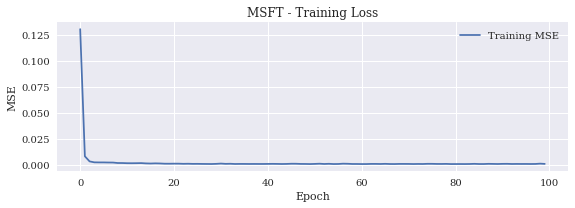

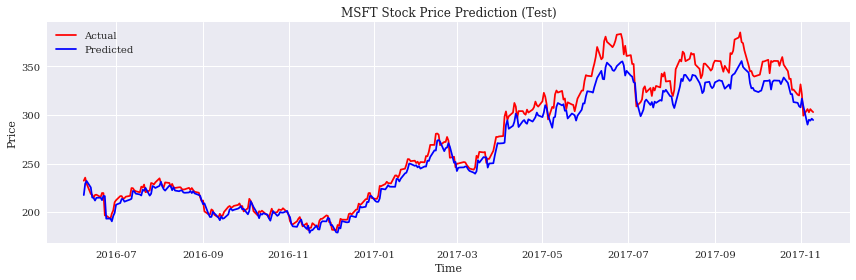


Training & evaluating TSLA
[TSLA] Epoch 1/100 - Train MSE: 0.134778
[TSLA] Epoch 10/100 - Train MSE: 0.002179
[TSLA] Epoch 20/100 - Train MSE: 0.001377
[TSLA] Epoch 30/100 - Train MSE: 0.001221
[TSLA] Epoch 40/100 - Train MSE: 0.001221
[TSLA] Epoch 50/100 - Train MSE: 0.001226
[TSLA] Epoch 60/100 - Train MSE: 0.001106
[TSLA] Epoch 70/100 - Train MSE: 0.001184
[TSLA] Epoch 80/100 - Train MSE: 0.001212
[TSLA] Epoch 90/100 - Train MSE: 0.001178
[TSLA] Epoch 100/100 - Train MSE: 0.001100


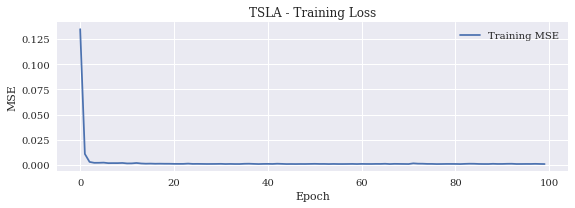

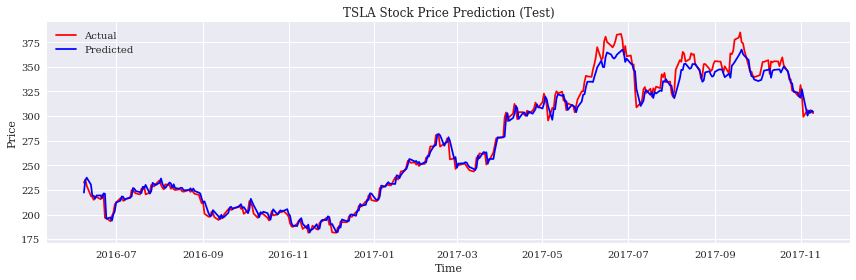


Summary metrics:


,Ticker,MSE,RMSE,MAE,MAPE(%),R2,Directional_Accuracy(%)
0,AAPL,53.810730,7.335580,5.788464,2.191826,0.986231,50.670241
1,AMZN,99.951012,9.997550,7.134969,2.373827,0.974426,48.257373
2,GOOGL,81.825111,9.045723,6.548965,2.236724,0.979063,47.989276
3,MSFT,169.420792,13.016174,9.985324,3.326315,0.956650,47.184987
4,TSLA,54.842251,7.405555,5.345826,1.879513,0.985968,50.402145


In [59]:
# ============================
# Run for 5 tickers and report
# ============================
TICKERS = ["AAPL", "AMZN", "GOOGL", "MSFT", "TSLA"]  # 'AAPL' spelling is intentional

results = []
for sym in TICKERS:
    print("\n" + "=" * 60)
    print(f"Training & evaluating {sym}")
    print("=" * 60)
    metrics = train_and_evaluate_symbol(
        sym,
        look_back=60,
        train_ratio=0.8,
        hidden_dim=32,
        num_layers=2,
        lr=0.01,
        batch_size=64,
        epochs=100,
        start="2010-01-01",
        end="2019-12-31",
        plot=True
    )
    row = {"Ticker": sym}
    row.update(metrics)
    results.append(row)

summary = pd.DataFrame(results)
print("\nSummary metrics:")
display(summary)
